## **Подготовка данных**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")
submission = pd.read_csv("sample_submission.csv")

### **Проведем преобразование данных для обучения**

In [4]:
test_id = app_test['SK_ID_CURR']
y_train=app_train['TARGET']

In [5]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
missing_values = missing_data(app_train)
missing_values.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [7]:
# закодируем категориальные признаки
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [8]:
#выровняем количество столбцов в train и test
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

In [9]:
#уберем выбросы в столбце DAYS_EMPLOYED для train и test
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [10]:
# Уберем целевую переменную из train
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

In [11]:
features = list(train.columns)
test = app_test.copy()

In [12]:
numeric = train.select_dtypes(exclude = ["object"]).columns
categorical = train.select_dtypes(include = ["object"]).columns

In [13]:
#заполним пропуски
missings = [] 

for i in categorical:
  missings.append(train[i].value_counts().idxmax())

for i in range(len(categorical)):
    train[categorical[i]].fillna(missings[i], inplace=True)

for i in numeric:
    train[i].fillna(train[i].median(), inplace=True)
    
for i in range(len(categorical)):
    test[categorical[i]].fillna(missings[i], inplace=True)

for i in numeric:
    test[i].fillna(test[i].median(), inplace=True)

## **Градиентный бустинг**

### **max_depth**

In [54]:
m_ds = [5, 8, 10, 12, 17]
def cv_function_m_d(data_to_cv, value):
    kf = KFold(n_splits=5)
    m_d_scores = []
    roc_auc_list = []
    for m_d in m_ds:
        print("ROC Scores for max_depth:", m_d)
        lgbm_model = LGBMClassifier(max_depth=m_d)
        for i, (train_index, test_index) in enumerate(kf.split(data_to_cv)):
            X_train, X_test = data_to_cv.iloc[train_index], data_to_cv.iloc[test_index]
            y_train, y_test = value[train_index], value[test_index]
            lgbm_model.fit(X_train, y_train)
            predict = lgbm_model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, predict)
            print(i, roc_auc)
            roc_auc_list.append(roc_auc)
        m_d_scores.append(np.mean(roc_auc_list))
    return m_d_scores

In [55]:
cv_score_m_d = cv_function_m_d(train, y_train)

ROC Scores for max_depth: 5
0 0.7523703235562492
1 0.7570948108413698
2 0.7488591102561638
3 0.7561947810152999
4 0.7561936159422825
ROC Scores for max_depth: 8
0 0.7558450238449134
1 0.7576763787000995
2 0.7504024628851254
3 0.7577578541510238
4 0.7569961660092007
ROC Scores for max_depth: 10
0 0.7531099929125228
1 0.7578446093881865
2 0.7493356600697817
3 0.7571921118136608
4 0.7575904869477585
ROC Scores for max_depth: 12
0 0.7516276484783445
1 0.7569554373184051
2 0.7496540339629281
3 0.757026499956197
4 0.756991869791686
ROC Scores for max_depth: 17
0 0.7521761460479424
1 0.7573193309435433
2 0.7501046571650931
3 0.7569248425144892
4 0.7569723487629454


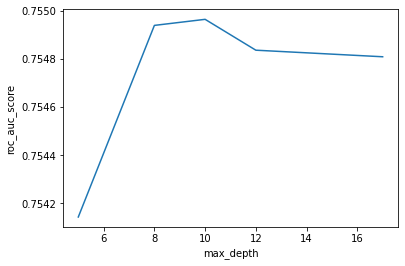

In [56]:
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.plot(m_ds, cv_score_m_d);

### **num_leaves**

In [57]:
n_ls = [7, 9, 12, 15, 20]
def cv_function_n_l(data_to_cv, value):
    kf = KFold(n_splits=5)
    n_l_scores = []
    roc_auc_list = []
    for n_l in n_ls:
      print("ROC Scores for num_leaves:", n_l)
      lgbm_model = LGBMClassifier(num_leaves=n_l)
      for i, (train_index, test_index) in enumerate(kf.split(data_to_cv)):
          X_train, X_test = data_to_cv.iloc[train_index], data_to_cv.iloc[test_index]
          y_train, y_test = value[train_index], value[test_index]
          lgbm_model.fit(X_train, y_train)
          predict = lgbm_model.predict_proba(X_test)[:,1]
          roc_auc = roc_auc_score(y_test, predict)
          print(i, roc_auc)
          roc_auc_list.append(roc_auc)
      n_l_scores.append(np.mean(roc_auc_list))
    return n_l_scores

In [58]:
cv_score_n_l = cv_function_n_l(train, y_train)

ROC Scores for num_leaves: 7
0 0.754434384522901
1 0.7548592306166252
2 0.7459682549439743
3 0.7543492127027005
4 0.7549174657558917
ROC Scores for num_leaves: 9
0 0.7555525004160665
1 0.7561491594848105
2 0.7464878194838933
3 0.7552701992600803
4 0.7557606997007894
ROC Scores for num_leaves: 12
0 0.7515823402735133
1 0.7566406318807074
2 0.74845757148437
3 0.7566030364990822
4 0.7563137509135248
ROC Scores for num_leaves: 15
0 0.7532009751737437
1 0.7563337662570042
2 0.7490369568423679
3 0.7573278448556111
4 0.7564975263189612
ROC Scores for num_leaves: 20
0 0.7551004262529339
1 0.758256284737296
2 0.7488369226675571
3 0.7573914125369383
4 0.7579454673444217


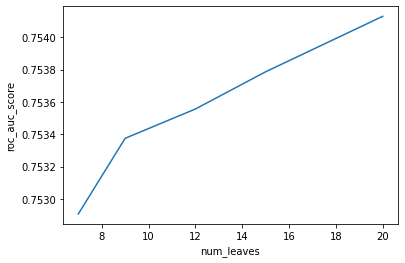

In [59]:
plt.xlabel('num_leaves')
plt.ylabel('roc_auc_score')
plt.plot(n_ls, cv_score_n_l);

### **n_estimators**

In [60]:
trees = [5, 10, 30, 50, 75]
def cv_function_trees(data_to_cv, value):
    kf = KFold(n_splits=5)
    trees_scores = []
    roc_auc_list = []
    for tree in trees:
      print("ROC Scores for n_estimators:", tree)
      lgbm_model = LGBMClassifier(num_leaves=tree)
      for i, (train_index, test_index) in enumerate(kf.split(data_to_cv)):
          X_train, X_test = data_to_cv.iloc[train_index], data_to_cv.iloc[test_index]
          y_train, y_test = value[train_index], value[test_index]
          lgbm_model.fit(X_train, y_train)
          predict = lgbm_model.predict_proba(X_test)[:,1]
          roc_auc = roc_auc_score(y_test, predict)
          print(i, roc_auc)
          roc_auc_list.append(roc_auc)
      trees_scores.append(np.mean(roc_auc_list))
    return trees_scores

In [61]:
cv_score_trees = cv_function_trees(train, y_train)

ROC Scores for n_estimators: 5
0 0.7511159207838118
1 0.7531450077041628
2 0.744046966568368
3 0.7523530041682631
4 0.7528839444970358
ROC Scores for n_estimators: 10
0 0.7557876479188067
1 0.7561722595009089
2 0.7483461989774859
3 0.7563473531188458
4 0.7564999745843294
ROC Scores for n_estimators: 30
0 0.7534873365145681
1 0.7584920055862845
2 0.7496711114353962
3 0.7569673689781801
4 0.7565819281881311
ROC Scores for n_estimators: 50
0 0.7525627399555812
1 0.757104029247613
2 0.7489746740870448
3 0.7557934760086165
4 0.7529215617147017
ROC Scores for n_estimators: 75
0 0.7486204060521892
1 0.7552189871074421
2 0.7479080025277214
3 0.7563034104193525
4 0.7531539950382014


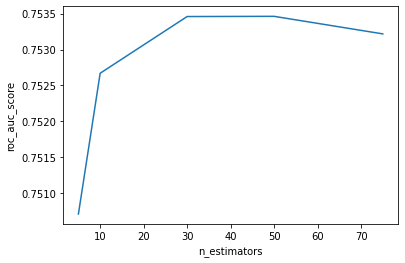

In [62]:
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.plot(trees, cv_score_trees);

### **GridSearchCV**

In [63]:
lgbm_model = LGBMClassifier()
parameters = {
    'max_depth': [5, 8, 10, 12, 17],
    'num_leaves' : [7, 9, 12, 15, 20],
    'n_estimators':[5, 10, 30, 50, 75]
}
grid_model = GridSearchCV(estimator=lgbm_model, param_grid=parameters,scoring='roc_auc', cv=5)

In [64]:
grid_model.fit(train, y_train)
None

In [65]:
grid_model.best_params_

{'max_depth': 12, 'n_estimators': 75, 'num_leaves': 15}

In [66]:
print('roc_auc score:', grid_model.best_score_)

roc_auc score: 0.7536138296091419


### **RandomizedSearchCV**

In [67]:
randomized_model = RandomizedSearchCV(lgbm_model, parameters,scoring='roc_auc', cv=5)
randomized_model.fit(train, y_train)
None

In [68]:
randomized_model.best_params_

{'max_depth': 5, 'n_estimators': 50, 'num_leaves': 15}

In [69]:
print('roc_auc score:', randomized_model.best_score_)

roc_auc score: 0.7495366598471567


### **Feature importance**

In [14]:
#Обучим модель на лучших признаках
#Возьмем параметры GridSearchCV, т.к. они дают лучший скор
best_lgbm_model = LGBMClassifier(max_depth=12, num_leaves=75, n_estimators=15, metric='roc_auc')
best_lgbm_model.fit(train, y_train)
None

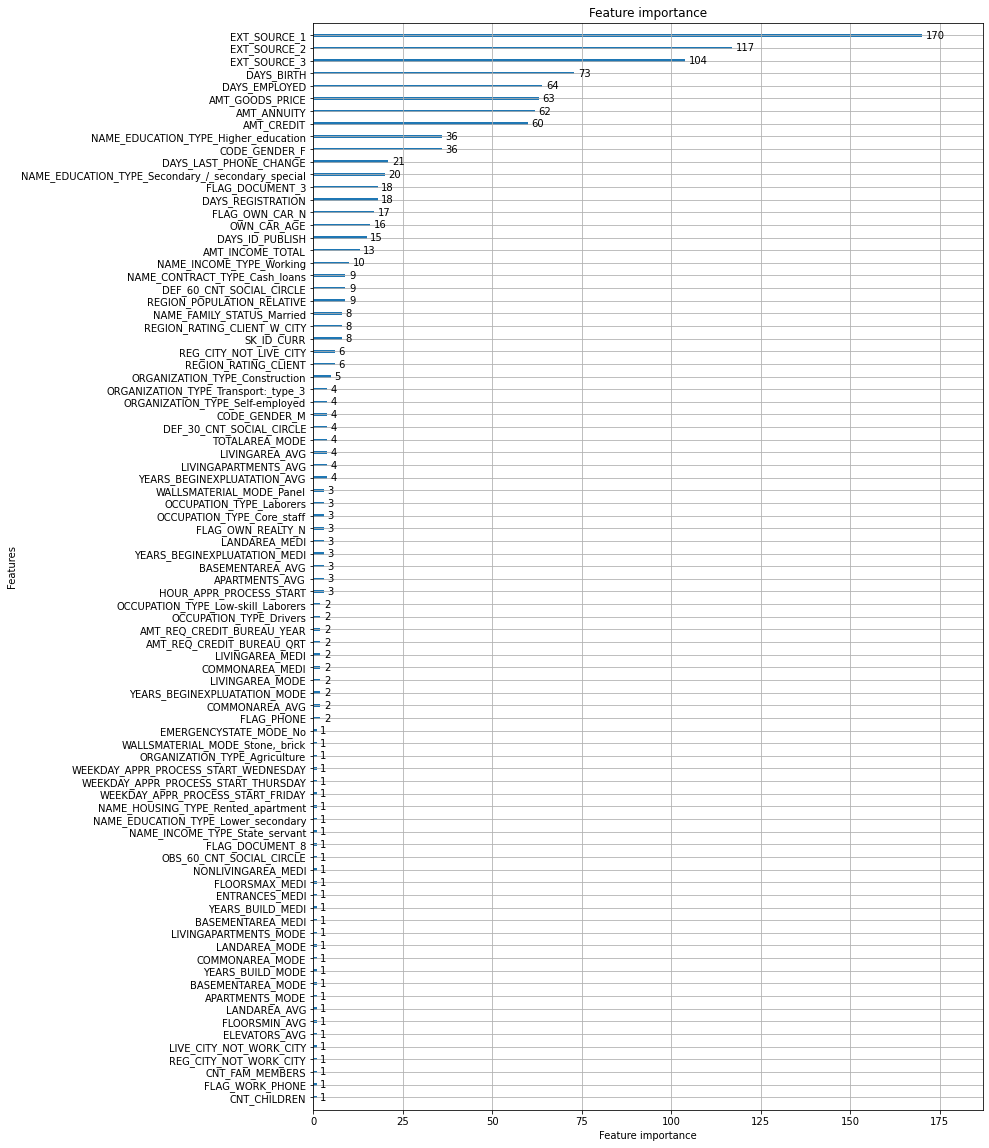

In [15]:
lgb.plot_importance(best_lgbm_model,  title='Feature importance', xlabel='Feature importance', ylabel='Features', figsize = (12,20))
None

In [16]:
predict_lgbm = best_lgbm_model.predict_proba(test)[:,1]

In [17]:
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = predict_lgbm

In [18]:
submission.to_csv('sub_lgbm.csv', index = False)

Таким образом, наиболее важными признаками являются EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, DAYS_EMPLOYED

## **Стекинг**
Возьмем следующие модели: 
1. LogisticRegressionCV, ROC AUC Score: 0.74284
2. DecisionTreeClassifier, ROC AUC Score: 0.71237
3. RandomForestClassifier, ROC AUC Score: 0.73039
4. LGBMClassifier, ROC AUC Score: 0.75007
5. LogisticRegression, ROC AUC Score: 0.68356

### **5 моделей**

In [19]:
estimators = [
    ('log_reg_cv', LogisticRegressionCV(cv =5, solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=3)),
    ('tree_model', DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 150, min_samples_split =100, random_state=10)),
    ('forest_model', RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)),
    ('lgbm_model', LGBMClassifier(max_depth=12, num_leaves=75, n_estimators=15, metric='roc_auc')),
    ('log_reg', LogisticRegression(solver='liblinear', random_state=1)) ]

In [20]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(train, y_train)
None

In [21]:
predict = clf.predict_proba(test)[:,1]

In [22]:
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = predict

In [23]:
submission.to_csv('sub_stacking.csv', index = False)

Скор для стекинга на лидерборде составил 0.72498, что несколько хуже скоров для LogisticRegressionCV (0.73780 на лидерборде) и LGBMClassifier (0.72750 на лидерборде)

### **4 модели**
Исключим лучшую модель из стекинга
1. Исключим LGBMClassifier, т.к. она дает лучший скор на кроссвалидации

In [24]:
estimators_4_1 = [
    ('log_reg_cv', LogisticRegressionCV(cv =5, solver='liblinear', penalty='l2', tol=1e-4, multi_class='ovr', random_state=3)),
    ('tree_model', DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 150, min_samples_split =100, random_state=10)),
    ('forest_model', RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)),
    ('log_reg', LogisticRegression(solver='liblinear', random_state=1)) ]

clf_4_1 = StackingClassifier(estimators=estimators_4_1, final_estimator=LogisticRegression())
clf_4_1.fit(train, y_train)
None

In [25]:
predict_4_1 = clf_4_1.predict_proba(test)[:,1]
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = predict_4_1
submission.to_csv('sub_stacking_4_1.csv', index = False)

Скор на лидерборде = 0.71532, что несколько хуже скора стекинга, включающего 5 моделей

2. Теперь исключим из ансамбля LogisticRegressionCV, т.к. она дает лучший скор на лидерборде

In [26]:
estimators_4_2 = [
    ('tree_model', DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 150, min_samples_split =100, random_state=10)),
    ('forest_model', RandomForestClassifier(random_state=10, max_depth=8, min_samples_split=20, n_estimators=30)),
    ('lgbm_model', LGBMClassifier(max_depth=12, num_leaves=75, n_estimators=15, metric='roc_auc')),
    ('log_reg', LogisticRegression(solver='liblinear', random_state=1)) ]

clf_4_2 = StackingClassifier(estimators=estimators_4_2, final_estimator=LogisticRegression())
clf_4_2.fit(train, y_train)
None

In [27]:
predict_4_2 = clf_4_2.predict_proba(test)[:,1]
submission['SK_ID_CURR'] = test_id.values
submission['TARGET'] = predict_4_2
submission.to_csv('sub_stacking_4_2.csv', index = False)

В данном случае скор на лидерборде = 0.72497, что незначительно ниже скора для стекинга, включающего 5 моделей и несколько выше скора для стекинга, исключающего LGBMClassifier.
Таким образом, лучший скор дает **LogisticRegressionCV**